In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import warnings
import util
warnings.filterwarnings('ignore')

run="dpscream_rce_large_3km_aa_default"
ndays=1

# temperature drift

In [6]:
file = "/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/{}/run/{}.eam.h0.2000-01-01-00000.nc".format(run, run)
ds = xr.open_dataset(file, chunks={'time':24*ndays,'lev':64,'ncol':2000})[["T","Z3"]]
t_init = ds['T'].isel(time=0).mean(dim=['ncol'])
z_init = ds.Z3.isel(time=0).mean(dim=['ncol'])
t_end = ds['T'].isel(time=slice(-ndays*24,-1)).mean(dim=['ncol','time'])
z_end = ds.Z3.isel(time=-1).mean(dim=['ncol'])
t_drift = t_end-t_init

t_init...
t_end...
t_drift...
done


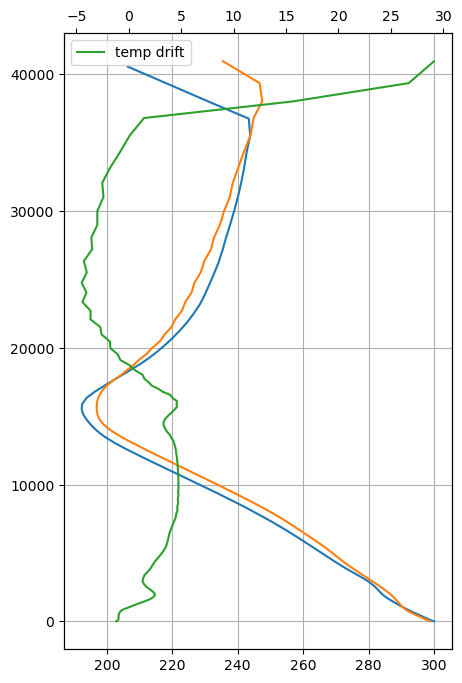

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5,8))
print("t_init...")
ax.plot(t_init, z_init, label="initial temp")
print("t_end...")
ax.plot(t_end, z_end, label=f"last {ndays} days")
print("t_drift...")
axt = ax.twiny()
axt.plot(t_drift, z_end, label="temp drift", color='C2')
print("done")
plt.legend()
ax.grid(True)
plt.savefig(f"../plots/large/temp_drift_{run}_{ndays}.png")
plt.show()

# OLR and PW var over time - movie

In [ ]:
ds = xr.open_dataset(file, chunks={'time':200,'ncol':2000})
print(ds.time[0].values, ds.time[-1].values, len(ds.time), (ds.time[-1].values-ds.time[0])/1e9/3600/24,"days")
olr = ds.FLUT
pw = ds.TMQ
pw_anom = pw - pw.mean(dim=['ncol'])
pw_var = pw_anom.var(dim=['ncol']).values
x = ds.crm_grid_x/1000
y = ds.crm_grid_y/1000
days = np.linspace(0,50,len(ds.time))
print(x.shape, olr.shape, days.shape)
del ds, pw, pw_anom

In [ ]:
cmapr="cividis_r"

# do it only 80 at a time to not go over the memory limit
for t in range(462,520,3): #range(len(olr.time)-2):
    print(t, end="... ")
    fig = plt.figure(figsize=plt.figaspect(0.3), layout='constrained')
    gs = GridSpec(2, 2, figure=fig, width_ratios=[100,4])
    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[1,0])
    cax = fig.add_subplot(gs[0,1])
    im_olr = ax0.tripcolor(y[t,:], x[t,:], olr[t,:].T,
                          vmin=80, vmax=310, shading="gouraud", cmap=cmapr)
    ax0.set(xlabel="km",ylabel="km",title="OLR (W/m$^2$)",
           xlim=[0,5120],ylim=[0,320])
    plt.colorbar(im_olr, label="W/m$^2$", cax=cax)
    ax1.plot(days[:t], pw_var[:t], 'k')
    ax1.set(xlim=[0,50],xlabel='days',
            ylim=[0,120],ylabel='PW var')

    plt.savefig(f"../plots/movie/large_304KSST_olr_pw/olr_pwvar_{t:04d}.png")
    print("saved")
    plt.close()
    